In [1]:
# importing liberaries
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# headers to send along with our HTTP requests
headers = {
    'Connection': 'close',
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'X-Requested-With': 'XMLHttpRequest',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
}

### Pass CIK here

In [3]:
# the central index key (CIK) for the company whose SEC filings we want to access
cik = '320193'    

### Defining Scraper

In [4]:
#Scraping the data and saving the data in a csv file.
def scraper(cik):

    # check if a CSV file with the data we need already exists, and if it has more than 1000 rows, exit the program
    try:
        df = pd.read_csv('commonStack'+cik+'.csv')
    except:
        # if the file doesn't exist yet, create an empty DataFrame with the appropriate column names
        df = pd.DataFrame(columns=['1. Title of Security','2. Transaction Date',
                            '2A. Deemed Execution Date',
                            '3. Transaction Code - Code',
                            '3. Transaction Code - V',
                            '4. Securities - Amount',
                            '4. Securities Acquired (A) or Disposed Of (D) - A/D',
                            '4. Securities - Price',
                            '5. Amount of Securities Beneficially Owned Following Reported Transaction(s)',
                            '6. Ownership Form: Direct (D) or Indirect (I)',
                            '7. Nature of Indirect Beneficial Ownership'])
        # save the empty DataFrame to a new CSV file
        df.to_csv('commonStack'+cik+'.csv', index=False)


    # method to get all tables from a html page
    def getting_tables_of_page(url):
        
        # send an HTTP GET request to the base URL to access the company's filings page
        res = requests.get(url, headers=headers)
        
        # parse the HTML content of the page using BeautifulSoup
        soup = BeautifulSoup(res.content,'html.parser')
        
        # find all the tables on the page
        table = soup.find_all('table', class_='')
        
        # returning all the tables found.
        return(table)


    # base URL for accessing the company's SEC filings
    url_main_page = f'https://www.sec.gov/Archives/edgar/data/'+cik+'/'

    # getting all tables of main page
    table_main_page = getting_tables_of_page(url_main_page)

    # for each table on the page, extract all the hyperlinks and save them in a list
    for links in table_main_page:
        link = links.find_all('a')
    all_href_main_page = [one_link.get('href') for one_link in link]

    # for each hyperlink in the list, access the linked page and extract any additional hyperlinks
    for href in all_href_main_page:
        
        # create the full URL for the linked page
        url_second_page = f'https://www.sec.gov' + href
        print("second page: "+ url_second_page)
        
        # getting all tables of Second page
        table_second_page = getting_tables_of_page(url_second_page)
        
        # Loop through each link in the second page
        for links in table_second_page:
            # Find all the hyperlinks in the link
            link = links.find_all('a')
            # Get the href for each hyperlink
            all_href = [one_link.get('href') for one_link in link]
            #print(all_href)
        
        # Construct the hyperlink for the next page of results
        result_href = 'https://www.sec.gov' + str(next((x for x in all_href if x.endswith("index.html")), ""))
        result_href
        
        # Send a request to the second page
        url_third_page = result_href
        
        print("Third page: "+url_third_page)
        #base_url = 'https://www.sec.gov/Archives/edgar/data/320193/000135445722000638/0001354457-22-000638-index.html'
        res = requests.get(url_third_page, headers=headers)
        
        # Parse the response HTML content
        soup = BeautifulSoup(res.content,'html.parser')
        # Find all the tables with class "tableFile"
        table = soup.find_all('table', class_ = 'tableFile')
        #table
        
        # checking if we have FORM 4 in the page or not
        gate_form4 = False
        for text in table:
            tds = text.find_all('td')
            
        for td in tds:
            #print(td.text)
            # Check if the td element contains the text "FORM 4"
            if 'FORM 4' in td.text:
                gate_form4 = True
        
        # Print whether a FORM 4 was found or not
        print('Found FORM 4: ',gate_form4) 
        
        # if FORM 4 found than getting hyperlinks for all the links in the page
        if(gate_form4):
            # Get the hyperlinks for all the links in the page
            for links in table:
                link = links.find_all('a')
            all_href = [one_link.get('href') for one_link in link]
        else:
            # If there is no FORM 4 in the page, continue to the next iteration of the loop
            continue 
        
        # Keep only the hyperlinks that point to XML or HTML files
        use_href = list()
        for temp_href in all_href:
            if temp_href.endswith(".xml"):
                #print(temp_href)
                use_href.append("https://www.sec.gov"+temp_href)
            #else: 
                #print('noice:' + temp_href)
                
        try:
            # Construct the hyperlink for the third page
            url_third_page = use_href[0]
        except:
            continue
        print("Third page: "+url_third_page)
        # Send a request to the third page
        res = requests.get(url_third_page, headers=headers)    
        # Parse the response HTML content
        soup = BeautifulSoup(res.content,'html.parser')
        # Find all the tables with class ""
        tables = soup.find_all('tbody', class_ = '')
        #print(tables)
        
        # Loop through all the rows in the tables and extract the data for Common Stock
        gate_common_stock = False
        for text in tables:
            tds = text.find_all('td')
        for td in tds:
            #print(td.text)
            # Check if the td element contains the text "Common Stock"
            if 'Common Stock' in td.text:
                gate_common_stock = True
                
        # Print whether Common Stock was found or not
        print('gate_common_stock: ',gate_common_stock)
        
        for table in tables:
            table_rows = table.find_all('tr', class_='')
        # if Common Stock is found
        if(gate_common_stock):
            # Loop through each row in the table
            for row in table_rows:
                # Get all the cells in the row
                table_cells = row.find_all('td', class_='')
                #print(table_cells)
                data = list()
                # Loop through each cell in the row and append the data to a list
                for cell in table_cells:
                    data.append(cell.text)
                    #print(data)
                
                # Clean up the data by removing non-numeric characters and commas
                final_row = [re.sub(r'[^\d\.]+', '', x).replace(',', '') if re.search(r'\$\d+\.?\d*\(\d+\)', x) 
                            else re.sub(r'[\n()]', '', x) for x in data]
                print(final_row)
                
                # Appending the final_row to the pandas DataFrame df and ignoring any exceptions
                try:
                    df = df.append(pd.Series(final_row, index=df.columns, name=''))
                except:
                    # If the final_row is not appended to the DataFrame, skip to the next iteration of the loop
                    continue
        else:
            # If there is no data on Common Stock in the page, continue to the next iteration of the loop
            continue
            
        # Exporting the DataFrame to a CSV file     
        df.to_csv('commonStack'+cik+'.csv', index=False)
            
        # Checking the number of rows in the CSV file and stopping the loop if it has more than 1000 rows
        #df2 = pd.read_csv('commonStack'+cik+'.csv')
        #if(df2.shape[0]>1000):sys.exit("File size reached 1000")
        
        
        print(url_third_page)
        print("saved one iteration")
    print('Data collected successfully')


### Defining Data cleaner

In [5]:
def dataCleaner(df):
    # drop columns with more than 50% null values
    df = df.dropna(thresh=len(df) / 2, axis=1)
    # drop rows with null values
    df.dropna(subset=df.columns, inplace=True)
    
    # Converting columns that have numeric value in object data type to float data type.
    df['4. Securities - Amount'] = df['4. Securities - Amount'].apply(lambda x: float(x.replace(',', '').replace('$', '')))
    df['4. Securities - Price'] = df['4. Securities - Price'].apply(lambda x: float(x.replace(',', '').replace('$', '')))
    df['5. Amount of Securities Beneficially Owned Following Reported Transaction(s)'] = df['5. Amount of Securities Beneficially Owned Following Reported Transaction(s)'].apply(lambda x: float(x.replace(',', '').replace('$', '')))
    
    # Convert the transaction date column to a datetime format
    df['2. Transaction Date'] = pd.to_datetime(df['2. Transaction Date'])
    return df

### Scrapping 

In [6]:
#Calling the scraper to scrap data from source
scraper(cik)

second page: https://www.sec.gov/Archives/edgar/data/320193/000032019324000075
Third page: https://www.sec.gov/Archives/edgar/data/320193/000032019324000075/0000320193-24-000075-index.html
Found FORM 4:  True
Third page: https://www.sec.gov/Archives/edgar/data/320193/000032019324000075/xslF345X05/wk-form4_1717453877.xml
gate_common_stock:  True
['Common Stock', '05/30/2024', '', 'S', '', '75,000', 'D', '191.581', '4,359,576', 'D', '']
['Common Stock', '', '', '', '', '', '', '', '56,000', 'I', 'By Spouse']
https://www.sec.gov/Archives/edgar/data/320193/000032019324000075/xslF345X05/wk-form4_1717453877.xml
saved one iteration
second page: https://www.sec.gov/Archives/edgar/data/320193/000192109424000702
Third page: https://www.sec.gov/Archives/edgar/data/320193/000192109424000702/0001921094-24-000702-index.html
Found FORM 4:  False
second page: https://www.sec.gov/Archives/edgar/data/320193/000032019324000073
Third page: https://www.sec.gov/Archives/edgar/data/320193/000032019324000073/

### Cleaning the data

In [ ]:
# read the CSV file into a pandas dataframe
file_name = 'commonStack'+cik+'.csv'
df = pd.read_csv('csvFiles/'+file_name)

In [ ]:
# display the first 5 rows of the dataframe
df.head()

,1. Title of Security,2. Transaction Date,2A. Deemed Execution Date,3. Transaction Code - Code,3. Transaction Code - V,4. Securities - Amount,4. Securities Acquired (A) or Disposed Of (D) - A/D,4. Securities - Price,5. Amount of Securities Beneficially Owned Following Reported Transaction(s),6. Ownership Form: Direct (D) or Indirect (I),7. Nature of Indirect Beneficial Ownership
0,Common Stock,02/09/2023,NaN,S,NaN,"3,0001",D,$85.88,"155,232",D,NaN
1,Common Stock,11/22/2022,NaN,S,NaN,"20,200",D,148.721,"31,505",D,NaN
2,Common Stock1,10/28/2022,NaN,S,NaN,"14,274",D,154.72,"272,698",D,NaN
3,Common Stock1,10/28/2022,NaN,S,NaN,"85,147",D,155.633,"187,551",D,NaN
4,Common Stock1,10/28/2022,NaN,S,NaN,"69,678",D,156.464,"117,873",D,NaN


In [ ]:
df.shape[1]

11

In [ ]:
# count null values in each column
null_counts = df.isnull().sum()
null_counts

1. Title of Security                                                              0
2. Transaction Date                                                              53
2A. Deemed Execution Date                                                       769
3. Transaction Code - Code                                                       53
3. Transaction Code - V                                                         683
4. Securities - Amount                                                           53
4. Securities Acquired (A) or Disposed Of (D) - A/D                              53
4. Securities - Price                                                            53
5. Amount of Securities Beneficially Owned Following Reported Transaction(s)      0
6. Ownership Form: Direct (D) or Indirect (I)                                     0
7. Nature of Indirect Beneficial Ownership                                      699
dtype: int64

In [ ]:
df = dataCleaner(df)

df.to_csv('cleanCsvFiles/'+file_name, index=False)

In [ ]:
df.head()

,1. Title of Security,2. Transaction Date,3. Transaction Code - Code,4. Securities - Amount,4. Securities Acquired (A) or Disposed Of (D) - A/D,4. Securities - Price,5. Amount of Securities Beneficially Owned Following Reported Transaction(s),6. Ownership Form: Direct (D) or Indirect (I)
0,Common Stock,2023-02-09,S,30001.0,D,85.880,155232.0,D
1,Common Stock,2022-11-22,S,20200.0,D,148.721,31505.0,D
2,Common Stock1,2022-10-28,S,14274.0,D,154.720,272698.0,D
3,Common Stock1,2022-10-28,S,85147.0,D,155.633,187551.0,D
4,Common Stock1,2022-10-28,S,69678.0,D,156.464,117873.0,D


### Performing Exploratory data analysis (EDA)

In [ ]:
# read the clean CSV file into a pandas dataframe
file_name = 'commonStack'+cik+'.csv'
df = pd.read_csv('cleanCsvFiles/'+file_name)

array([[<AxesSubplot:title={'center':'4. Securities - Amount'}>,
        <AxesSubplot:title={'center':'4. Securities - Price'}>],
       [<AxesSubplot:title={'center':'5. Amount of Securities Beneficially Owned Following Reported Transaction(s)'}>,
        <AxesSubplot:>]], dtype=object)

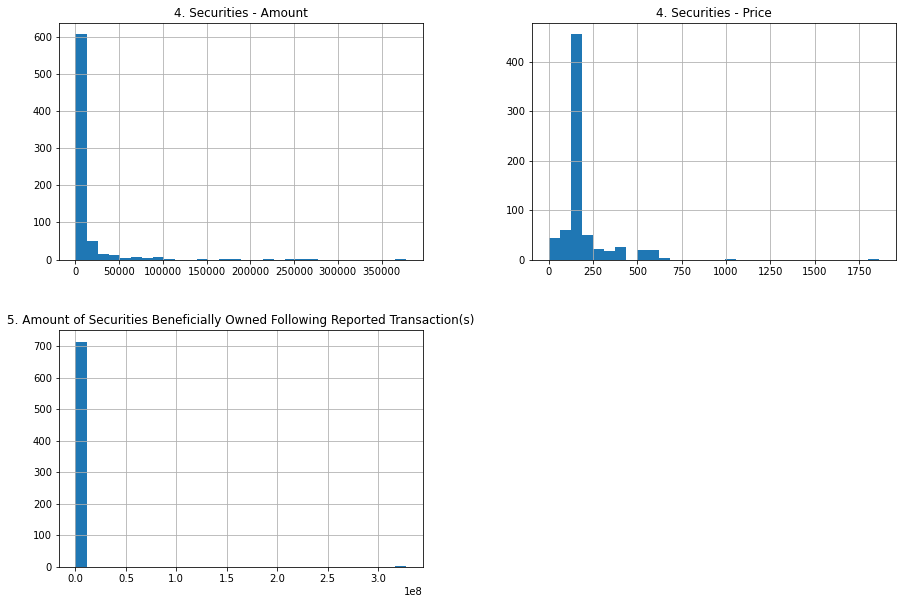

In [ ]:
df.hist(bins=30, figsize=(15, 10))

In [ ]:
df['2. Transaction Date'] = pd.to_datetime(df['2. Transaction Date'])

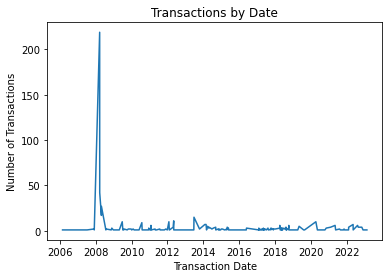

In [ ]:
#Transactions by Date

date_counts = df.groupby('2. Transaction Date').size()

plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Transaction Date')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Date')
plt.show()

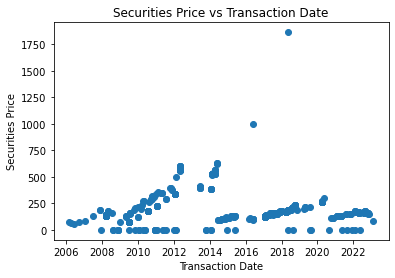

In [ ]:
# extract the Securities Price and Transaction Date columns and convert to numeric format
price = df['4. Securities - Price']
date = df['2. Transaction Date']

# create a scatter plot of Securities Price versus Transaction Date
plt.scatter(date, price)

# set the x-axis label to Transaction Date and y-axis label to Securities Price
plt.xlabel('Transaction Date')
plt.ylabel('Securities Price')

# set the title of the plot
plt.title('Securities Price vs Transaction Date')

# display the plot
plt.show()

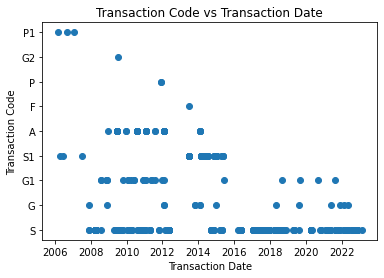

In [ ]:
# extract the Securities Price and Transaction Date columns and convert to numeric format
Transaction_Code = df['3. Transaction Code - Code']
date = df['2. Transaction Date']

# create a scatter plot of Securities Price versus Transaction Date
plt.scatter(date, Transaction_Code)

# set the x-axis label to Transaction Date and y-axis label to Securities Price
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Code')

# set the title of the plot
plt.title('Transaction Code vs Transaction Date')

# display the plot
plt.show()